<a href="https://colab.research.google.com/github/RishitSingh10/LSA-NMF-Topic-Modelling/blob/main/Latent_Semantic_Analysis_%26_Non_Negative_Matrix_Factorization_for_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Implementing LSA (Latent Semantic Analysis)





## 1.1. Using Gensim LSI

### 1.1.1. Imports

In [ ]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.1.2. Loading Data

In [ ]:
def load_data(path):
    """
    Input  : path of folder containing docs
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    for file_name in os.listdir(folder_path):
        with open(os.path.join(folder_path, file_name), "r") as file:
            doc_content = file.read()
            documents_list.append(doc_content)

    print("Total Number of Documents:",len(documents_list))
    return documents_list

### 1.1.3. Preprocessing Data

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


### 1.1.4. Prepare Corpus


In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


### 1.1.5. Create an LSA model using Gensim


In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

### 1.1.6. Determine the number of topics


In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
folder_path = "/content/Docs"

In [ ]:
document_list = load_data(folder_path)
clean_text=preprocess_data(document_list)

Total Number of Documents: 344


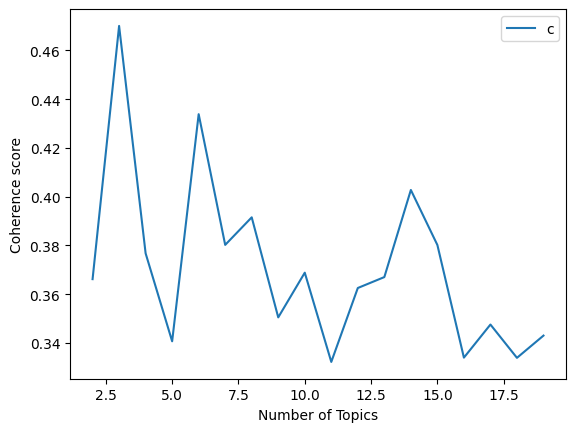

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,1
plot_graph(clean_text,start,stop,step)

In [ ]:
# LSA Model
number_of_topics=3 # highest coherence score
words=10
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.683*"0" + 0.394*"1" + 0.270*"2" + 0.187*"5" + 0.187*"3" + 0.162*"4" + 0.126*"6" + 0.114*"anomali" + 0.106*"7" + 0.099*"8"'), (1, '0.262*"anomali" + -0.229*"0" + 0.203*"data" + -0.202*"5" + 0.201*"al" + 0.200*"et" + 0.184*"use" + 0.179*"detect" + 0.164*"model" + 0.161*"learn"'), (2, '0.669*"0" + -0.460*"1" + -0.338*"2" + -0.191*"3" + -0.177*"5" + -0.177*"4" + -0.145*"6" + -0.128*"7" + -0.118*"9" + -0.113*"8"')]


Results are not very interpretable

## 1.2. Using Truncated SVD

### 1.2.1. Imports

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from wordcloud import WordCloud

### 1.2.2. Load Data

In [ ]:
folder_path = "/content/Docs"
document_list = load_data(folder_path)

Total Number of Documents: 344


### 1.2.3. Preprocessing Data & Preparing the Document-Term Matrix



In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',smooth_idf=True)
# under the hood - lowercasing,removing special chars,removing stop words
input_matrix = np.asarray(vectorizer.fit_transform(document_list).todense())

In [ ]:
input_matrix.shape

(344, 83730)

In [ ]:
type(input_matrix)

numpy.ndarray

### 1.2.4. Create a LSA model using TruncatedSVD

In [ ]:
def create_LSA_SVD(input_matrix, num_topics):
  svd_modelling = TruncatedSVD(n_components= num_topics, algorithm = 'randomized', n_iter = 100, random_state = 122)
  svd_modelling.fit(input_matrix)
  components = svd_modelling.components_

  return components

### 1.2.5. Determining the number of topics

In [ ]:
def calculate_pairwise_cosine_similarity(input_matrix, num_topics):
  components = create_LSA_SVD(input_matrix, num_topics = num_topics)
  coherence_score = 0.0
  num_pairs = 0
  for i in range(num_topics):
    for j in range(i+1, num_topics):
        sim_matrix = cosine_similarity(components[i].reshape(1, -1), components[j].reshape(1, -1))
        coherence_score += sim_matrix[0][0]
        num_pairs += 1

  coherence_score /= num_pairs

  return coherence_score

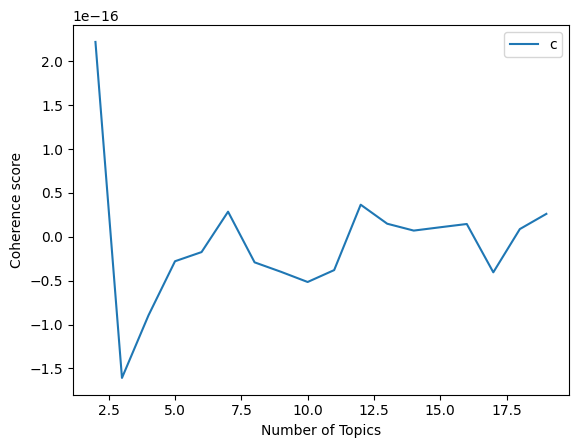

In [ ]:
def plot_graph(input_matrix, start, stop, step):

    coherence_values = []
    for num_topics in range(start, stop, step):
      coherence_values.append(calculate_pairwise_cosine_similarity(input_matrix, num_topics))

    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,1
plot_graph(np.asarray(input_matrix),start,stop,step)

we get highest cosine similarity score number of topics 2 and 12

### 1.2.6. Get the topics

In [ ]:
# Number of topics = 2

svd_modeling= TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=122)
svd_modeling.fit(np.asarray(input_matrix))
components=svd_modeling.components_
vocab = vectorizer.get_feature_names_out()

In [ ]:
def get_topics(components):
  topic_word_list = []
  for i, comp in enumerate(components):
    terms_comp = zip(vocab,comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    topic=" "
    for t in sorted_terms:
      topic= topic + ' ' + t[0]
    topic_word_list.append(topic)

  return topic_word_list

get_topics(components)

['  anomaly detection data al et time series',
 '  series time forecasting mts multivariate gp graph']

In [ ]:
# Number of topics = 12

svd_modeling= TruncatedSVD(n_components=12, algorithm='randomized', n_iter=100, random_state=122)
svd_modeling.fit(np.asarray(input_matrix))
components=svd_modeling.components_
vocab = vectorizer.get_feature_names_out()

In [ ]:
components.shape

(12, 83730)

In [ ]:
topic_word_list = get_topics(components)
topic_word_list

['  anomaly detection data al et time series',
 '  series time forecasting mts multivariate gp graph',
 '  translation quality mt annotation language automation corpus',
 '  gp regret ucb algorithm gaussian xt optimization',
 '  graph node nodes gad gp graphs subgraph',
 '  gp ucb regret image et al images',
 '  robot human agent annotation corpus robots agents',
 '  robot uni00000013 uni00000011 98 99 agent human',
 '  annotation corpus 99 98 speech 97 annotator',
 '  uni00000013 uni00000011 uni00000048 uni00000024 uni00000018 uni00000014 data',
 '  video anomaly uni00000013 ad et rgb al',
 '  les des la dans une parole détection']

### 1.2.7. Visualization

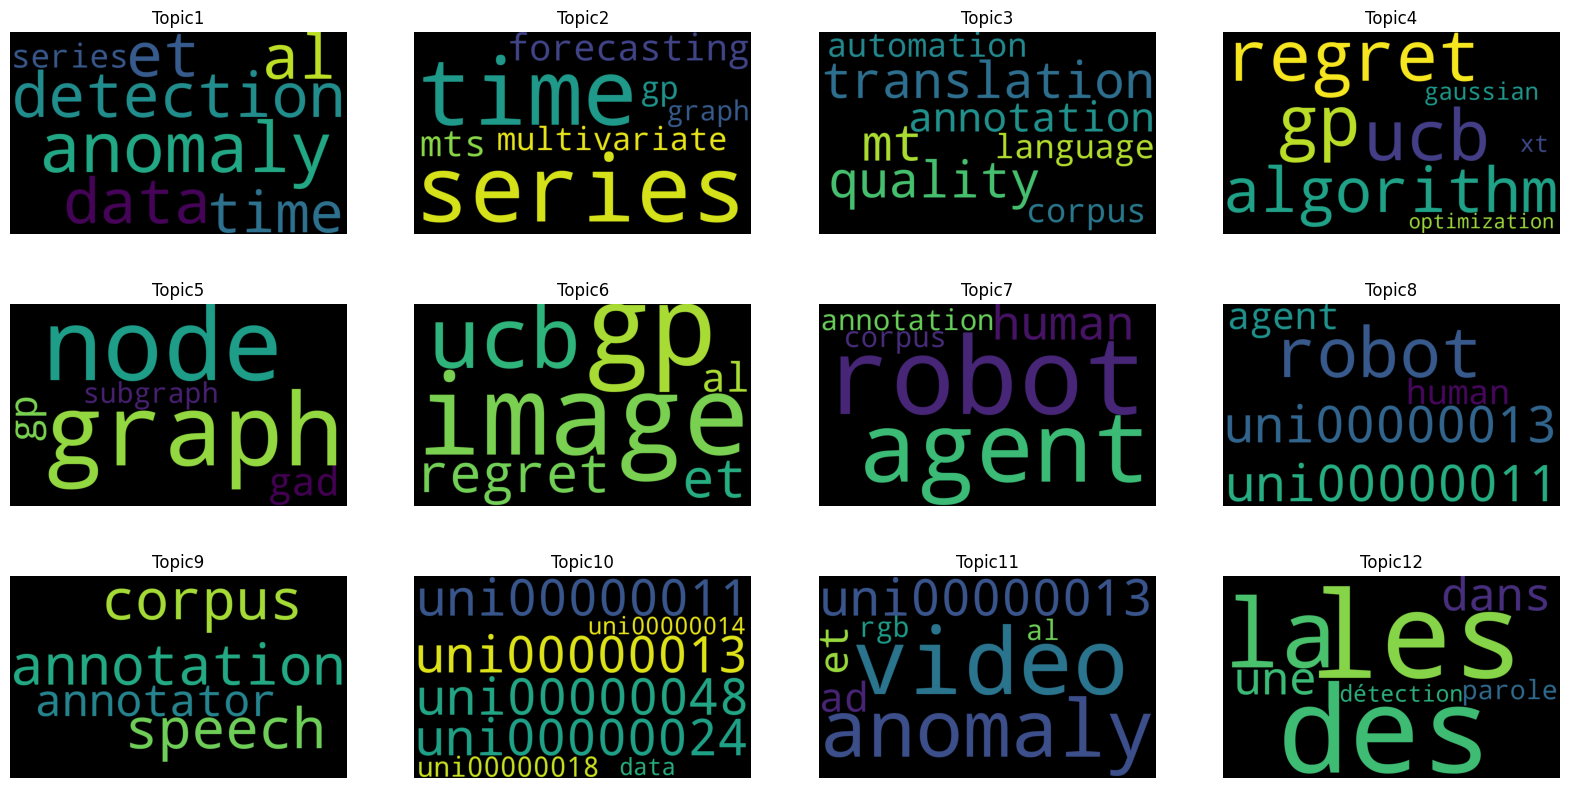

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))

# Generate and display word clouds for each topic
for idx, ax in enumerate(axs.flat):
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[idx])
  ax.imshow(wc)
  ax.set_title(f"Topic{idx+1}")
  ax.axis("off")


# 2. Implementing NMF (Non-Negative Matrix Factorization)

## 2.1 Imports

In [ ]:
from sklearn.decomposition import NMF

## 2.2 Create NMF model

In [ ]:
def create_NMF_model(input_matrix, num_topics):
  NMF_model = NMF(n_components=num_topics, random_state=1)
  W = NMF_model.fit_transform(np.asarray(input_matrix))
  H = NMF_model.components_

  return W, H

## 2.2 Determining the number of topics

In [ ]:
def calculate_pairwise_cosine_similarity(input_matrix, num_topics):
  W, H = create_NMF_model(input_matrix, num_topics = num_topics)
  coherence_score = 0.0
  num_pairs = 0
  for i in range(num_topics):
    for j in range(i+1, num_topics):
        sim_matrix = cosine_similarity(H[i].reshape(1, -1), H[j].reshape(1, -1))
        coherence_score += sim_matrix[0][0]
        num_pairs += 1

  coherence_score /= num_pairs

  return coherence_score

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


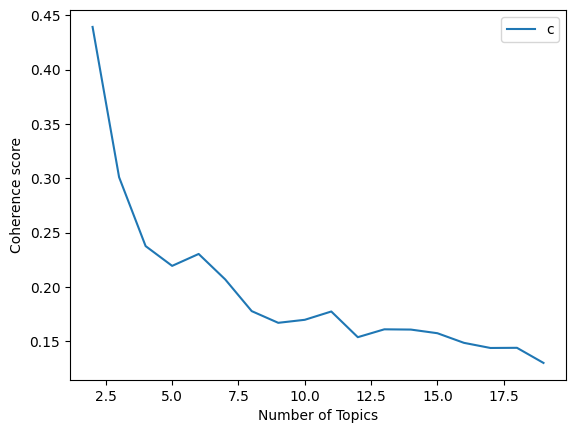

In [ ]:
def plot_graph(input_matrix, start, stop, step):

    coherence_values = []
    for num_topics in range(start, stop, step):
      coherence_values.append(calculate_pairwise_cosine_similarity(input_matrix, num_topics))

    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,1
plot_graph(np.asarray(input_matrix),start,stop,step)

In [ ]:
W, H = create_NMF_model(input_matrix, 2)
get_topics(H)

['  anomaly detection data al et normal anomalies',
 '  series time data forecasting et al mts']

In [ ]:
W, H = create_NMF_model(input_matrix, 11)
get_topics(H)

['  anomaly detection data anomalies normal set density',
 '  series time forecasting mts multivariate data temporal',
 '  translation quality mt translator qa translators text',
 '  gp regret ucb optimization xt bkb gaussian',
 '  graph node nodes gad graphs subgraph anomaly',
 '  al et image anomaly images detection data',
 '  robot agent human agents robots policy automation',
 '  anomaly 99 98 97 image detection 96',
 '  annotation corpus speech sentences sentence home data',
 '  uni00000013 uni00000011 uni00000048 uni00000024 uni00000018 uni00000014 uni00000031',
 '  video et al anomaly ad abnormal rgb']

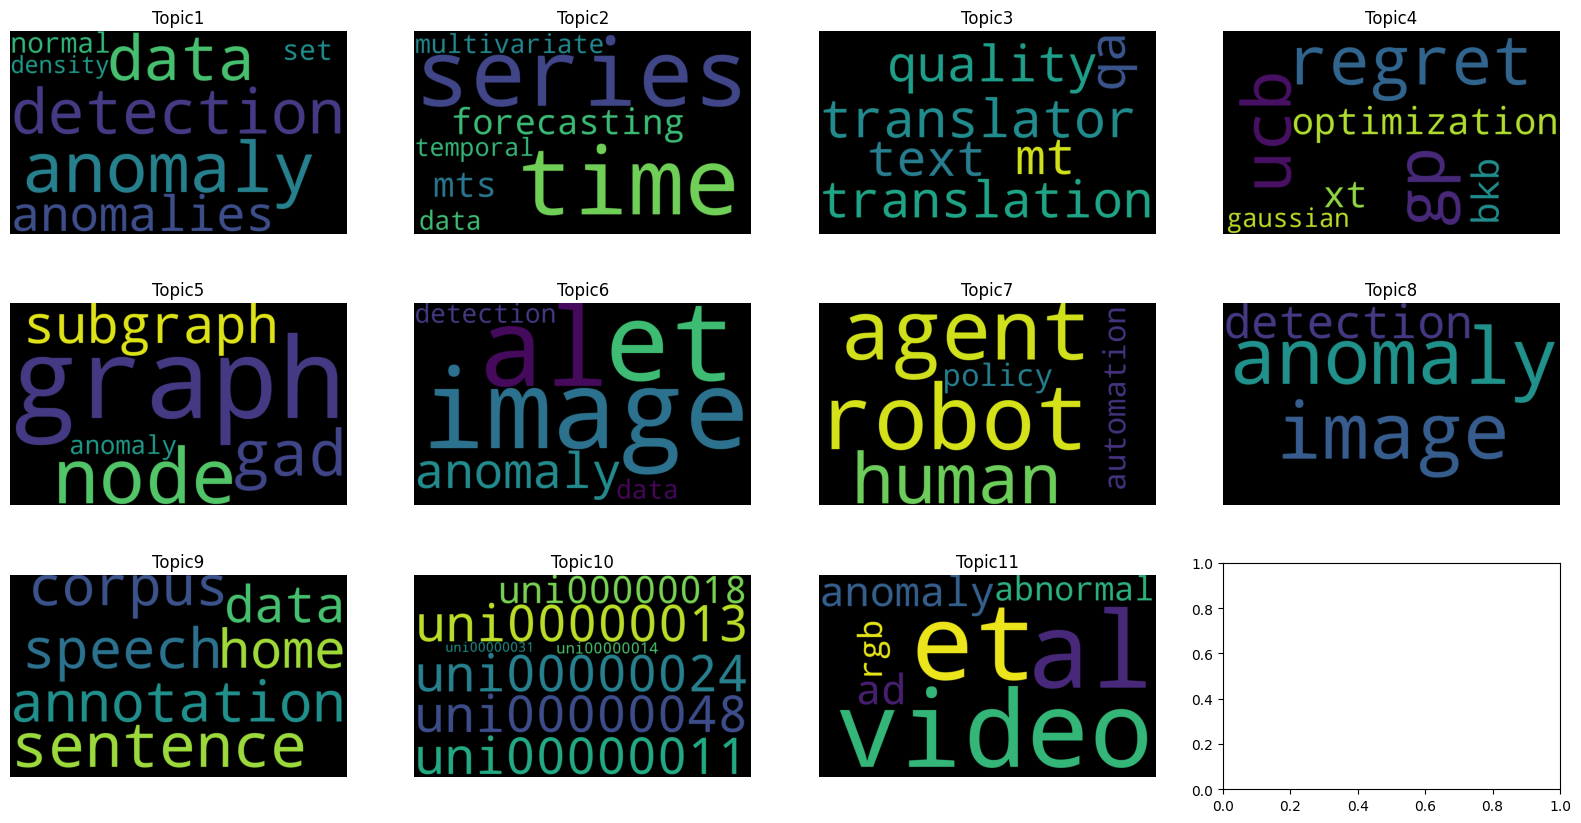

In [ ]:
topic_word_list = get_topics(H)

fig, axs = plt.subplots(3, 4, figsize=(20, 10))

# Generate and display word clouds for each topic
for idx, ax in enumerate(axs.flat[:-1]):
  wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[idx])
  ax.imshow(wc)
  ax.set_title(f"Topic{idx+1}")
  ax.axis("off")